In [1]:
import nibabel as nib #to read the niftis
from glob import glob #to quicly read the nifti paths
import logging # for printing monai info
import sys # for printing monai info
import monai #for this experiment monai will be the main framework for 2d segmentation
import torch
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Resized
)
from torch.utils.tensorboard import SummaryWriter

from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter) #Aparently this allow to read direcly a set of niftis
from monai.utils import first
from matplotlib import pyplot as plt
from monai.metrics import DiceMetric

import numpy as np
print(monai.__version__) 
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)


0.7.0
MONAI version: 0.7.0
Numpy version: 1.21.4
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.11.1
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.4
einops version: 0.3.2
transformers version: 4.12.4

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
isles_data_root = '/Users/sebastianotalora/work/postdoc/data/ISLES/TRAINING/'

In [3]:
cbf_paths = sorted(glob(isles_data_root+'*/*CBF*/*nii'))
cbv_paths = sorted(glob(isles_data_root+'*/*CBV*/*nii'))
mtt_paths = sorted(glob(isles_data_root+'*/*MTT*/*nii'))
tmx_paths = sorted(glob(isles_data_root+'*/*Tmax*/*nii'))
lbl_paths = sorted(glob(isles_data_root+'*/*OT*/*nii'))
print(cbf_paths[-1])

/Users/sebastianotalora/work/postdoc/data/ISLES/TRAINING/case_94/SMIR.Brain.XX.O.CT_CBF.346202/SMIR.Brain.XX.O.CT_CBF.346202.nii


In [4]:
imtrans = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

In [5]:
ds = ArrayDataset(cbf_paths, imtrans, lbl_paths, segtrans)

In [6]:
loader = torch.utils.data.DataLoader(
    ds, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)
im, seg = first(loader)
print(im.shape, seg.shape)

torch.Size([1, 1, 224, 224, 1]) torch.Size([1, 1, 224, 224, 1])


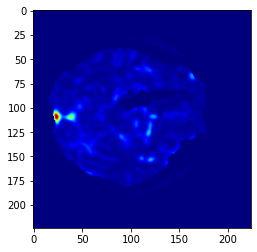

In [7]:
sample_im, sample_seg = im.numpy(), seg.numpy()
plt.imshow(sample_im[0,0,:,:,0],cmap='jet')

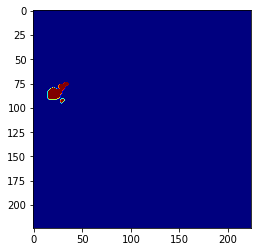

In [8]:
plt.imshow(sample_seg[0,0,:,:,0],cmap='jet')

In [9]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

In [10]:
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 1),
    kernel_size = (3,3,1),
    #dropout = 0.2,
    num_res_units=0,
).to(device)

In [13]:
monai.networks.nets.UNet?

In [14]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [15]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()

In [16]:
for epoch in range(2):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{10}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(loader) // loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                roi_size = (96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)

----------
epoch 1/10


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 2 for tensor number 1 in the list.

In [27]:
inputs.shape

torch.Size([1, 1, 224, 224, 1])

In [18]:
labels.shape

torch.Size([1, 1, 224, 224, 1])

In [23]:
pp = torch.zeros((0,1,224,224,1))

In [20]:
pp.shape

torch.Size([1, 1, 224, 224, 1])

In [21]:
model??

In [25]:
model(pp,pp)

TypeError: forward() takes 2 positional arguments but 3 were given

In [26]:
model.forward??

In [28]:
from PIL import Image

In [40]:
pp = Image.open('/Users/sebastianotalora/work/postdoc/federated_learning/fedem/tmp_dir_circles/seg0.png')

In [41]:
pp = np.array(pp)
np.histogram(pp)

(array([9940,    0,    0,    0,    0,    0,    0,    0,    0, 6444]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]))

In [42]:
pp = Image.open('/Users/sebastianotalora/work/postdoc/federated_learning/fedem/tmp_dir_squares/seg0.png')

In [43]:
pp = np.array(pp)
np.histogram(pp)

(array([9504,    0,    0,    0,    0,    0,    0,    0,    0, 6880]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]))